# Imports

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!pip install nltk -q

In [33]:
import pandas as pd
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,pipeline
)
from peft import LoraConfig, get_peft_model,PeftModel
from sklearn.metrics import classification_report
from tqdm.auto import tqdm # Para barras de progresso
import nltk

# Carregando subj

In [34]:
# Load model

base_model_name = "bert-base-uncased"
adapter_dir = "/content/drive/MyDrive/Mestrado/Modelos de Linguagem/Trabalho LLM/Tarefa Subjetividade Clef2025-1/subj_obj_lora_final"

subj_base_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=2,
    id2label={0: "OBJ", 1: "SUBJ"},
    label2id={"OBJ": 0, "SUBJ": 1}
)

subj_model = PeftModel.from_pretrained(subj_base_model, adapter_dir)
subj_tokenizer = AutoTokenizer.from_pretrained(adapter_dir)

subj_model.eval()
if torch.cuda.is_available():
    subj_model.to("cuda")
    print("Modelo movido para a GPU.")

# ============================================
# 0️⃣ LOAD DATA (Adicionado para ser executável)
# ============================================
# Substitua pelos seus caminhos de arquivo reais
train_file_path = '/content/drive/MyDrive/Mestrado/Modelos de Linguagem/Trabalho LLM/Tarefa Subjetividade Clef2025-1/task1/data/english/train_en.tsv'
dev_file_path = '/content/drive/MyDrive/Mestrado/Modelos de Linguagem/Trabalho LLM/Tarefa Subjetividade Clef2025-1/task1/data/english/dev_en.tsv'

df_sub = pd.read_csv(train_file_path, sep="\t")
dev_sub = pd.read_csv(dev_file_path, sep="\t")

# ============================================
# 1️⃣ PREPROCESS DATA
# ============================================

# Example: labels are "OBJ" and "SUBJ"
label_map = {"OBJ": 0, "SUBJ": 1}

# Map to numeric labels
df_sub["label"] = df_sub["label"].map(label_map)
dev_sub["label"] = dev_sub["label"].map(label_map)

print("Label distribution (train):")
print(df_sub["label"].value_counts())
print("\nLabel distribution (dev):")
print(dev_sub["label"].value_counts())

# ============================================
# 2️⃣ DEFINE DATASET CLASS
# ============================================

class SubjTextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df["sentence"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        item = {key: val.squeeze() for key, val in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

# ============================================
# 5️⃣ CREATE DATASETS
# ============================================

subj_train_dataset = SubjTextDataset(df_sub, subj_tokenizer)
subj_dev_dataset = SubjTextDataset(dev_sub, subj_tokenizer)

print(f"Train dataset size: {len(subj_train_dataset)}")
print(f"Dev dataset size: {len(subj_dev_dataset)}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo movido para a GPU.
Label distribution (train):
label
0    532
1    298
Name: count, dtype: int64

Label distribution (dev):
label
1    240
0    222
Name: count, dtype: int64
Train dataset size: 830
Dev dataset size: 462


# Carregando gen

In [35]:
# --- 2. Defina os caminhos ---
base_model_name = "bert-base-uncased"
# O caminho exato onde você salvou os adaptadores no seu Drive
adapter_dir = "/content/drive/MyDrive/Mestrado/Modelos de Linguagem/Trabalho LLM/Tarefa Deteccao semeval 2024-8/human_ai_lora_final"


# --- 3. Carregue o Modelo Base ---
gen_base_model = AutoModelForSequenceClassification.from_pretrained(
    base_model_name,
    num_labels=2,
    id2label={0: "human", 1: "AI"},
    label2id={"human": 0, "AI": 1}
)

# --- 4. Aplique os Adaptadores LoRA ---
gen_model = PeftModel.from_pretrained(gen_base_model, adapter_dir)

gen_tokenizer = AutoTokenizer.from_pretrained(adapter_dir)

print("Modelo e tokenizer carregados do Google Drive!")

# --- 6. Prepare o modelo para inferência ---
gen_model.eval()
if torch.cuda.is_available():
    gen_model.to("cuda")
    print("Modelo movido para a GPU.")

train_file_path = "/content/drive/MyDrive/Mestrado/Modelos de Linguagem/Trabalho LLM/Tarefa Deteccao semeval 2024-8/SubtaskA-20251024T182540Z-1-001/SubtaskA/subtaskA_train_monolingual.jsonl"
df_train = pd.read_json(train_file_path, lines=True)
dev_file_path = "/content/drive/MyDrive/Mestrado/Modelos de Linguagem/Trabalho LLM/Tarefa Deteccao semeval 2024-8/SubtaskA-20251024T182540Z-1-001/SubtaskA/subtaskA_dev_monolingual.jsonl"
df_dev = pd.read_json(dev_file_path, lines=True)

# Função para criar o rótulo binário
def map_label(model_name):
    if model_name == 'human':
        return 'human'
    else:
        return 'AI' # Agrupa 'chatGPT', 'davinci', etc.

# Aplica a função para criar uma nova coluna de rótulo legível
df_train['label_str'] = df_train['model'].apply(map_label)
df_dev['label_str'] = df_dev['model'].apply(map_label)

# Mapeia os rótulos de string para inteiros
label_map = {"human": 0, "AI": 1}
df_train["label_id"] = df_train["label_str"].map(label_map)
df_dev["label_id"] = df_dev["label_str"].map(label_map)

print("Label distribution (train):")
print(df_train["label_str"].value_counts())
print("\nLabel distribution (dev):")
print(df_dev["label_str"].value_counts())

class GenTextDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df["text"].tolist()
        self.labels = df["label_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # MUDANÇA: Removido padding, return_tensors.
        # Deixe o DataCollator do Trainer cuidar disso.
        enc = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_len,
            # Não adicione padding aqui!
        )

        # Retorne um dicionário simples.
        # O Trainer cuidará de agrupar e converter para tensores.
        item = {
            "input_ids": enc["input_ids"],
            "attention_mask": enc["attention_mask"],
            "labels": label
        }
        return item

# Passa os DataFrames corretos
gen_train_dataset = GenTextDataset(df_train, gen_tokenizer)
gen_dev_dataset = GenTextDataset(df_dev, gen_tokenizer)

print(f"Train dataset size: {len(gen_train_dataset)}")
print(f"Dev dataset size: {len(gen_dev_dataset)}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo e tokenizer carregados do Google Drive!
Modelo movido para a GPU.
Label distribution (train):
label_str
human    63351
AI       56406
Name: count, dtype: int64

Label distribution (dev):
label_str
AI       2500
human    2500
Name: count, dtype: int64
Train dataset size: 119757
Dev dataset size: 5000


In [36]:
import nltk
from tqdm import tqdm
from transformers import pipeline

# ---------------------------------------------------------
# 0. PREPARE SENTENCE SPLITTING
# ---------------------------------------------------------

print("Baixando o tokenizador de sentenças do NLTK ('punkt')...")
nltk.download('punkt_tab', quiet=True)

print("Dividindo textos em sentenças... (Isso pode levar um momento)")

train_file_path = "/content/drive/MyDrive/Mestrado/Modelos de Linguagem/Trabalho LLM/Tarefa Deteccao semeval 2024-8/SubtaskA-20251024T182540Z-1-001/SubtaskA/subtaskA_dev_monolingual.jsonl"
df_detection = pd.read_json(train_file_path, lines=True)
df_detection['sentences_list'] = df_detection['text'].apply(
    lambda x: nltk.sent_tokenize(str(x))
)

df_exploded = df_detection.explode('sentences_list')
df_exploded = df_exploded.rename(columns={'sentences_list': 'sentence'})
df_exploded = df_exploded.drop(columns=['text'])
df_exploded = df_exploded.dropna(subset=['sentence']).reset_index(drop=True)

total_sentences = len(df_exploded)
print(f"Dataset original de {len(df_detection)} textos foi dividido em {total_sentences} sentenças.")

# ---------------------------------------------------------
# 1. SUBJECTIVE VS OBJECTIVE MODEL (LoRA PEFT)
# ---------------------------------------------------------

print("\nInicializando o pipeline de subjetividade...")

subj_pipe = pipeline(
    "text-classification",
    model=subj_model,
    tokenizer=subj_tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    batch_size=32
)

sentences_list = df_exploded['sentence'].tolist()

print(f"Classificando {total_sentences} sentenças (SUBJ vs OBJ)...")

subj_results = list(
    tqdm(subj_pipe(sentences_list, truncation=True), total=total_sentences)
)

df_exploded['subj_label'] = [r['label'] for r in subj_results]
df_exploded['subj_score'] = [r['score'] for r in subj_results]

print("Classificação de subjetividade concluída.")

# ---------------------------------------------------------
# 2. HUMAN vs AI CLASSIFICATION MODEL
# ---------------------------------------------------------
# gen_model and gen_tokenizer must already be loaded before this code.
# Example:
# gen_model = AutoModelForSequenceClassification.from_pretrained(...)
# gen_tokenizer = AutoTokenizer.from_pretrained(...)

print("\nInicializando o pipeline de detecção (Human vs AI)...")

gen_pipe = pipeline(
    "text-classification",
    model=gen_model,
    tokenizer=gen_tokenizer,
    device=0 if torch.cuda.is_available() else -1,
    batch_size=32
)

print(f"Classificando {total_sentences} sentenças (HUMAN vs AI)...")

gen_results = list(
    tqdm(gen_pipe(sentences_list, truncation=True), total=total_sentences)
)

df_exploded['gen_label'] = [r['label'] for r in gen_results]
df_exploded['gen_score'] = [r['score'] for r in gen_results]

print("Classificação de geração concluída.")

# ---------------------------------------------------------
# 3. SHOW RESULTS
# ---------------------------------------------------------

print("\n--- Análise Concluída ---")
print(df_exploded.head(10))

print("\nContagem SUBJ/OBJ por modelo de origem:")
print(df_exploded.groupby('model')['subj_label'].value_counts(normalize=True))

print("\nContagem HUMAN/AI por modelo de origem:")
print(df_exploded.groupby('model')['gen_label'].value_counts(normalize=True))


Baixando o tokenizador de sentenças do NLTK ('punkt')...
Dividindo textos em sentenças... (Isso pode levar um momento)


Device set to use cuda:0


Dataset original de 5000 textos foi dividido em 84282 sentenças.

Inicializando o pipeline de subjetividade...
Classificando 84282 sentenças (SUBJ vs OBJ)...


100%|██████████| 84282/84282 [00:00<00:00, 3472026.02it/s]
Device set to use cuda:0


Classificação de subjetividade concluída.

Inicializando o pipeline de detecção (Human vs AI)...
Classificando 84282 sentenças (HUMAN vs AI)...


100%|██████████| 84282/84282 [00:00<00:00, 3595446.80it/s]

Classificação de geração concluída.

--- Análise Concluída ---
   label   model   source  id  \
0      1  bloomz  wikihow   0   
1      1  bloomz  wikihow   0   
2      1  bloomz  wikihow   0   
3      1  bloomz  wikihow   0   
4      1  bloomz  wikihow   0   
5      1  bloomz  wikihow   0   
6      1  bloomz  wikihow   0   
7      1  bloomz  wikihow   0   
8      1  bloomz  wikihow   1   
9      1  bloomz  wikihow   1   

                                            sentence subj_label  subj_score  \
0           Giving gifts should always be enjoyable.        OBJ    0.534707   
1  However, it may become stressful when trying t...        OBJ    0.735707   
2  This wikiHow will help you figure out exactly ...       SUBJ    0.504216   
3  If you're having trouble deciding between two ...       SUBJ    0.535345   
4  Make sure it's appropriate - some people don't...       SUBJ    0.607313   
5  Don't forget to include any special requests y...       SUBJ    0.712006   
6  Write down all...

In [37]:
output_csv_path = "/content/drive/MyDrive/Mestrado/Modelos de Linguagem/Trabalho LLM/Tarefa Deteccao semeval 2024-8/detection_dev_with_subj_and_gen_scores.csv"

print(f"Salvando DataFrame explodido em {output_csv_path}...")

# Salva o DataFrame em um arquivo CSV
# index=False evita salvar o índice do pandas como uma coluna extra
df_exploded.to_csv(output_csv_path, index=False)

print("Arquivo CSV salvo com sucesso no Google Drive!")

Salvando DataFrame explodido em /content/drive/MyDrive/Mestrado/Modelos de Linguagem/Trabalho LLM/Tarefa Deteccao semeval 2024-8/detection_dev_with_subj_and_gen_scores.csv...
Arquivo CSV salvo com sucesso no Google Drive!


In [66]:
df_exploded

,label,model,source,id,sentence,subj_label,subj_score,gen_label,gen_score,gen_target
0,1,bloomz,wikihow,0,Giving gifts should always be enjoyable.,OBJ,0.534707,AI,0.911093,AI
1,1,bloomz,wikihow,0,"However, it may become stressful when trying t...",OBJ,0.735707,AI,0.977709,AI
2,1,bloomz,wikihow,0,This wikiHow will help you figure out exactly ...,SUBJ,0.504216,AI,0.713550,AI
3,1,bloomz,wikihow,0,If you're having trouble deciding between two ...,SUBJ,0.535345,human,0.995984,AI
4,1,bloomz,wikihow,0,Make sure it's appropriate - some people don't...,SUBJ,0.607313,human,0.688377,AI
...,...,...,...,...,...,...,...,...,...,...
84277,0,human,peerread,4999,"- From paper: ""We considered a frozen set of h...",OBJ,0.935641,human,0.853683,human
84278,0,human,peerread,4999,"This argument is not valid in ML, maybe if you...",OBJ,0.873363,human,0.995448,human
84279,0,human,peerread,4999,Why a common hyper parameter tuning procedure ...,OBJ,0.957259,human,0.509568,human
84280,0,human,peerread,4999,"random search (Bergstra and Bengio, JMLR 2012)...",OBJ,0.922443,human,0.782345,human


In [50]:
from sklearn.metrics import f1_score, classification_report

# Ensure column types are consistent
df_exploded['subj_label'] = df_exploded['subj_label'].astype(str)
df_exploded['gen_label']  = df_exploded['gen_label'].astype(str)
df_exploded['gen_target'] = df_exploded['model'].apply(
    lambda x: "human" if str(x).lower() == "human" else "AI"
)
df_exploded['gen_target'] = df_exploded['gen_target'].astype(str)

# -----------------------------------------
# F1 for SUBJECTIVE sentences only
# -----------------------------------------
df_only_subj = df_exploded[df_exploded['subj_label'] == 'SUBJ']

f1_only_subj = f1_score(
    df_only_subj['gen_target'],
    df_only_subj['gen_label'],
    average='macro'
)

print("\n🔵 F1 Score (only SUBJECTIVE sentences):", f1_only_subj)
print("\nClassification Report (SUBJECTIVE only):")
print(classification_report(df_only_subj['gen_target'], df_only_subj['gen_label']))

# -----------------------------------------
# F1 for OBJECTIVE sentences only
# -----------------------------------------
df_only_obj = df_exploded[df_exploded['subj_label'] == 'OBJ']

f1_only_obj = f1_score(
    df_only_obj['gen_target'],
    df_only_obj['gen_label'],
    average='macro'
)

print("\n🟢 F1 Score (only OBJECTIVE sentences):", f1_only_obj)
print("\nClassification Report (OBJECTIVE only):")
print(classification_report(df_only_obj['gen_target'], df_only_obj['gen_label']))



🔵 F1 Score (only SUBJECTIVE sentences): 0.568190444161522

Classification Report (SUBJECTIVE only):
              precision    recall  f1-score   support

          AI       0.29      0.45      0.35      2477
       human       0.84      0.73      0.78      9963

    accuracy                           0.67     12440
   macro avg       0.57      0.59      0.57     12440
weighted avg       0.73      0.67      0.70     12440


🟢 F1 Score (only OBJECTIVE sentences): 0.5568244667022609

Classification Report (OBJECTIVE only):
              precision    recall  f1-score   support

          AI       0.34      0.55      0.42     18604
       human       0.80      0.62      0.70     53238

    accuracy                           0.60     71842
   macro avg       0.57      0.58      0.56     71842
weighted avg       0.68      0.60      0.62     71842



# Task
Analyze the relationship between text subjectivity and human/AI classification by calculating a subjectivity index for each original text from `df_exploded`, applying the human/AI detection model (`gen_pipe`) to the full original texts in `df_detection`, merging these results, and suggesting initial analyses or visualizations.

## Calculate Subjectivity Index for Original Texts

### Subtask:
Group the already processed `df_exploded` by original text `id` to calculate a 'subjectivity index' (e.g., the proportion of subjective sentences) for each full text. Store these indices in a new DataFrame.


**Reasoning**:
To calculate the subjectivity index for each original text, I will group the `df_exploded` DataFrame by `id`, count subjective sentences, and compute the proportion of subjective sentences to the total sentences for each group, storing the results in a new DataFrame.



In [67]:
# Create the normalized subjectivity score for each sentence
df_exploded['normalized_subj_score'] = df_exploded.apply(
    lambda row: row['subj_score'] if row['subj_label'] == 'SUBJ' else (1 - row['subj_score']),
    axis=1
)

df_subjectivity_index = df_exploded.groupby('id').apply(
    lambda x: x['normalized_subj_score'].mean(),
    include_groups=False
).reset_index(name='subjectivity_index')

print("Subjectivity Index per original text ID:")
print(df_subjectivity_index.head())

Subjectivity Index per original text ID:
   id  subjectivity_index
0   0            0.439437
1   1            0.195749
2   2            0.185255
3   3            0.432823
4   4            0.191996


**Reasoning**:
Now that the subjectivity index for each original text has been calculated, I will apply the human/AI detection model (`gen_pipe`) to the full original texts in `df_detection`. This involves using the `gen_pipe` to classify the `text` column of `df_detection` and storing the resulting `gen_label` and `gen_score` in new columns within `df_detection`.



In [53]:
print("Classifying full original texts (HUMAN vs AI) using gen_pipe...")

detection_texts = df_detection['text'].tolist()
gen_detection_results = list(
    tqdm(gen_pipe(detection_texts, truncation=True), total=len(detection_texts))
)

df_detection['gen_label'] = [r['label'] for r in gen_detection_results]
df_detection['gen_score'] = [r['score'] for r in gen_detection_results]

print("Full original texts classified.")
print(df_detection.head())

Classifying full original texts (HUMAN vs AI) using gen_pipe...


100%|██████████| 5000/5000 [00:00<00:00, 3249886.87it/s]

Full original texts classified.
                                                text  label   model   source  \
0  Giving gifts should always be enjoyable.  Howe...      1  bloomz  wikihow   
1  Yveltal (Japanese: ユベルタル) is one of the main a...      1  bloomz  wikihow   
2  If you'd rather not annoy others by being rude...      1  bloomz  wikihow   
3  If you're interested in visiting gravesite(s) ...      1  bloomz  wikihow   
4  The following are some tips for becoming succe...      1  bloomz  wikihow   

   id                                     sentences_list gen_label  gen_score  
0   0  [Giving gifts should always be enjoyable., How...     human   0.587361  
1   1  [Yveltal (Japanese: ユベルタル) is one of the main ...        AI   0.889536  
2   2  [If you'd rather not annoy others by being rud...     human   0.869003  
3   3  [If you're interested in visiting gravesite(s)...     human   0.993670  
4   4  [The following are some tips for becoming succ...        AI   0.745152  


**Reasoning**:
I need to merge the `df_subjectivity_index` (which contains subjectivity scores per original text ID) with the `df_detection` DataFrame (which contains the human/AI classification for the full original texts) to combine all relevant information for analysis.



In [68]:
df_merged = pd.merge(df_detection, df_subjectivity_index, on='id', how='left')

print("Merged DataFrame head:")
print(df_merged.head())

Merged DataFrame head:
                                                text  label   model   source  \
0  Giving gifts should always be enjoyable.  Howe...      1  bloomz  wikihow   
1  Yveltal (Japanese: ユベルタル) is one of the main a...      1  bloomz  wikihow   
2  If you'd rather not annoy others by being rude...      1  bloomz  wikihow   
3  If you're interested in visiting gravesite(s) ...      1  bloomz  wikihow   
4  The following are some tips for becoming succe...      1  bloomz  wikihow   

   id                                     sentences_list gen_label  gen_score  \
0   0  [Giving gifts should always be enjoyable., How...     human   0.587361   
1   1  [Yveltal (Japanese: ユベルタル) is one of the main ...        AI   0.889536   
2   2  [If you'd rather not annoy others by being rud...     human   0.869003   
3   3  [If you're interested in visiting gravesite(s)...     human   0.993670   
4   4  [The following are some tips for becoming succ...        AI   0.745152   

   subjec

In [104]:
# Ensure column types are consistent
df_merged['gen_target'] = df_merged['model'].apply(
    lambda x: "human" if str(x).lower() == "human" else "AI"
)

# -----------------------------------------
# F1 for SUBJECTIVE texts only
# -----------------------------------------
subj_index_towards_subj_df = df_merged[df_merged['subjectivity_index'] >=0.2]

subj_index_subj_score = f1_score(
    subj_index_towards_subj_df['gen_target'],
    subj_index_towards_subj_df['gen_label'],
    average='macro'
)

print("\n🔵 F1 Score (only SUBJECTIVE texts):", subj_index_subj_score)
print("\nClassification Report (SUBJECTIVE only):")
print(classification_report(subj_index_towards_subj_df['gen_target'], subj_index_towards_subj_df['gen_label']))

# -----------------------------------------
# F1 for OBJECTIVE texts only
# -----------------------------------------
subj_index_towards_sub_df = df_merged[df_merged['subjectivity_index'] <0.2]

subj_index_obj_score = f1_score(
    subj_index_towards_sub_df['gen_target'],
    subj_index_towards_sub_df['gen_label'],
    average='macro'
)

print("\n🟢 F1 Score (only OBJECTIVE texts):", subj_index_obj_score)
print("\nClassification Report (OBJECTIVE only):")
print(classification_report(subj_index_towards_sub_df['gen_target'], subj_index_towards_sub_df['gen_label']))



🔵 F1 Score (only SUBJECTIVE texts): 0.6590707147547602

Classification Report (SUBJECTIVE only):
              precision    recall  f1-score   support

          AI       0.78      0.43      0.56      1036
       human       0.66      0.90      0.76      1257

    accuracy                           0.69      2293
   macro avg       0.72      0.67      0.66      2293
weighted avg       0.71      0.69      0.67      2293


🟢 F1 Score (only OBJECTIVE texts): 0.73090822127836

Classification Report (OBJECTIVE only):
              precision    recall  f1-score   support

          AI       0.77      0.72      0.74      1464
       human       0.69      0.75      0.72      1243

    accuracy                           0.73      2707
   macro avg       0.73      0.73      0.73      2707
weighted avg       0.73      0.73      0.73      2707



<Axes: >

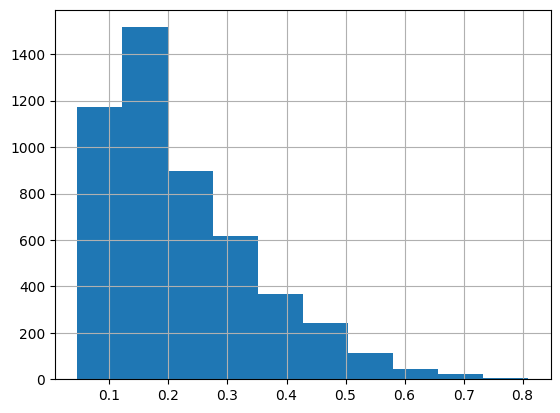

In [82]:
df_merged.subjectivity_index.hist()

In [102]:
df_merged[df_merged.id==2905]["text"].values[0]

"I think the depth of knowledge required of today's society is far greater than what it was in the renaissance; for example, a modern engineer is far more knowledgable than Da-Vinci, and so are the biologists and painters. If someone reached Da-Vinci skill levels in everything he did, but in a modern context, they would just be someone who is quite good at a lot of things, but far from being notable in any of them, as they would be competing with a global industry of people who have been training their whole lives in just that one thing.\n\nIt takes far too long and too much specialisation to reach the level of skill/knowledge on something that would make you globally notable these days. \n\nAs mentioned by others here, what makes them notable is their *relative* knowledge levels compared to the rest of the world. They didn't know much, but jeez, compared to everyone else back then, they knew everything. And they got there without the internet, supportive government and societal infras

In [100]:
df_merged[df_merged.subjectivity_index>0.7]

,text,label,model,source,id,sentences_list,gen_label,gen_score,subjectivity_index,true_label,gen_target
1068,Eleocharis acicularis var.\n Eleocharis austra...,1,bloomz,wikipedia,1068,"[Eleocharis acicularis var., Eleocharis austra...",AI,0.980735,0.732598,AI,AI
2036,"No , Americans are not obsessed by gun . They ...",1,bloomz,reddit,2036,"[No , Americans are not obsessed by gun ., The...",AI,0.818442,0.712758,AI,AI
2248,"No, it's mental and emotional state of mind th...",1,bloomz,reddit,2248,"[No, it's mental and emotional state of mind t...",AI,0.711665,0.707709,AI,AI
2321,"We can't be sure, but it seems unlikely that h...",1,bloomz,reddit,2321,"[We can't be sure, but it seems unlikely that ...",human,0.975946,0.787508,AI,AI
2400,Because they are ignorant and don't know what ...,1,bloomz,reddit,2400,[Because they are ignorant and don't know what...,human,0.765138,0.779526,AI,AI
2531,There are lots of reasons - one of the primary...,0,human,reddit,2531,[There are lots of reasons - one of the primar...,human,0.988361,0.782426,human,human
2690,Because they don't know who they can trust - a...,0,human,reddit,2690,[Because they don't know who they can trust - ...,AI,0.647079,0.707161,human,human
2743,"Many organisms thrive in acidic environments, ...",0,human,reddit,2743,"[Many organisms thrive in acidic environments,...",AI,0.952382,0.702760,human,human
2803,**Socialism** \nSocialism is a big word that ...,0,human,reddit,2803,[**Socialism** \nSocialism is a big word that...,human,0.998551,0.740354,human,human
2905,I think the depth of knowledge required of tod...,0,human,reddit,2905,[I think the depth of knowledge required of to...,human,0.992313,0.716855,human,human


## Initial Analyses and Visualizations Suggestions

To analyze the relationship between text subjectivity and human/AI classification, we can consider the following approaches:

1.  **Distribution of Subjectivity Index by AI/Human Classification (Ground Truth):**
    *   Visualize the `subjectivity_index` for texts whose `model` (ground truth) is 'human' versus those whose `model` is 'AI'. This can be done using histograms or box plots.

2.  **Distribution of Subjectivity Index by Predicted AI/Human Classification:**
    *   Visualize the `subjectivity_index` for texts classified as 'human' by `gen_label` versus those classified as 'AI' by `gen_label`. This helps understand if the model's predictions correlate with subjectivity.

3.  **Correlation Analysis:**
    *   Calculate the correlation between `subjectivity_index` and `gen_score` (AI confidence score) overall, and broken down by `model` (ground truth) or `gen_label` (predicted label).

4.  **Misclassification Analysis based on Subjectivity:**
    *   Identify texts where `model` != `gen_label` (misclassifications).
    *   Analyze the `subjectivity_index` distribution for these misclassified texts to see if subjectivity plays a role in misclassifications.

5.  **Scatter Plot:**
    *   Create scatter plots showing `subjectivity_index` against `gen_score`, with points colored by `model` (ground truth) or `gen_label` (predicted label). This can reveal patterns.

## Visualize Subjectivity Index Distribution by Ground Truth

### Subtask:
Visualize the distribution of `subjectivity_index` for texts classified as 'human' versus 'AI' based on their `model` (ground truth) using histograms or box plots.


**Reasoning**:
To visualize the distribution of `subjectivity_index` for human-generated and AI-generated texts, I will create two subplots side-by-side using `matplotlib` and `seaborn`. The `model` column in `df_merged` provides the ground truth (human or AI).



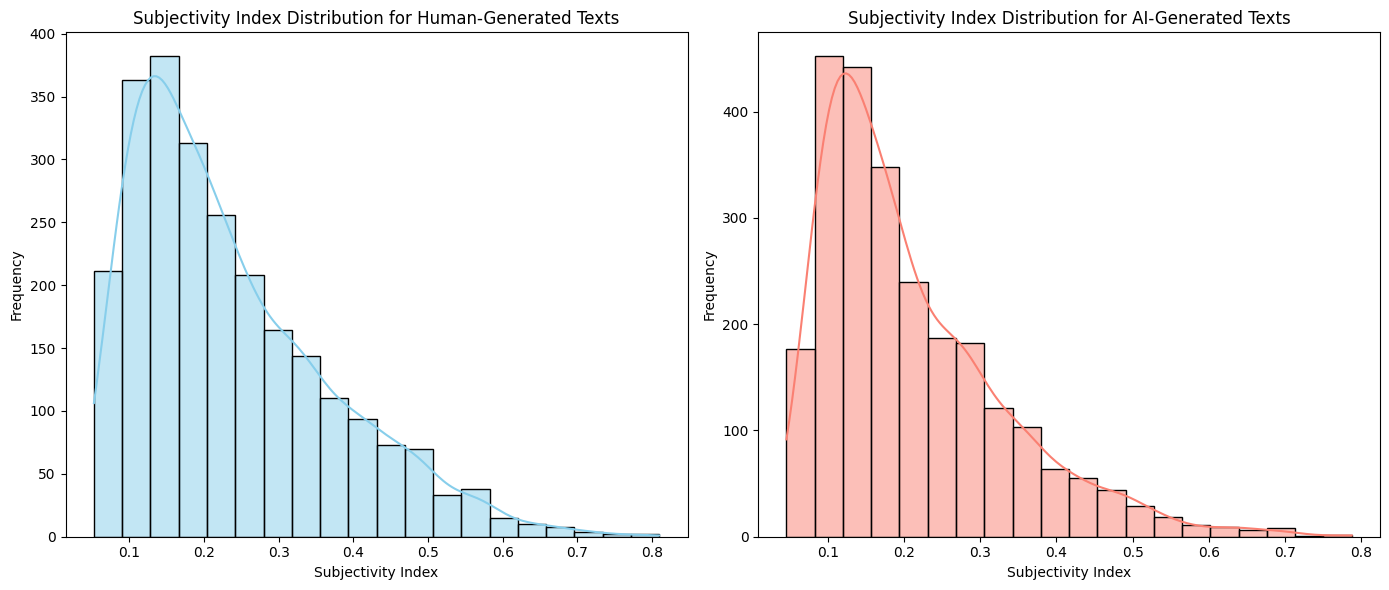

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for human-generated and AI-generated texts
df_human = df_merged[df_merged['model'] == 'human']
df_ai = df_merged[df_merged['model'] == 'bloomz'] # Assuming 'bloomz' represents AI in this dataset based on previous output

plt.figure(figsize=(14, 6))

# Subplot 1: Subjectivity Index for Human-Generated Texts
plt.subplot(1, 2, 1)
sns.histplot(df_human['subjectivity_index'], bins=20, kde=True, color='skyblue')
plt.title('Subjectivity Index Distribution for Human-Generated Texts')
plt.xlabel('Subjectivity Index')
plt.ylabel('Frequency')

# Subplot 2: Subjectivity Index for AI-Generated Texts
plt.subplot(1, 2, 2)
sns.histplot(df_ai['subjectivity_index'], bins=20, kde=True, color='salmon')
plt.title('Subjectivity Index Distribution for AI-Generated Texts')
plt.xlabel('Subjectivity Index')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Visualize Subjectivity Index Distribution by Predicted Classification

### Subtask:
Visualize the distribution of `subjectivity_index` for texts classified as 'human' versus 'AI' based on their `gen_label` (predicted classification) using histograms or box plots.


**Reasoning**:
To visualize the distribution of `subjectivity_index` based on the predicted human/AI classification, I will filter `df_merged` by `gen_label` and then use `seaborn.histplot` to create histograms for each category.



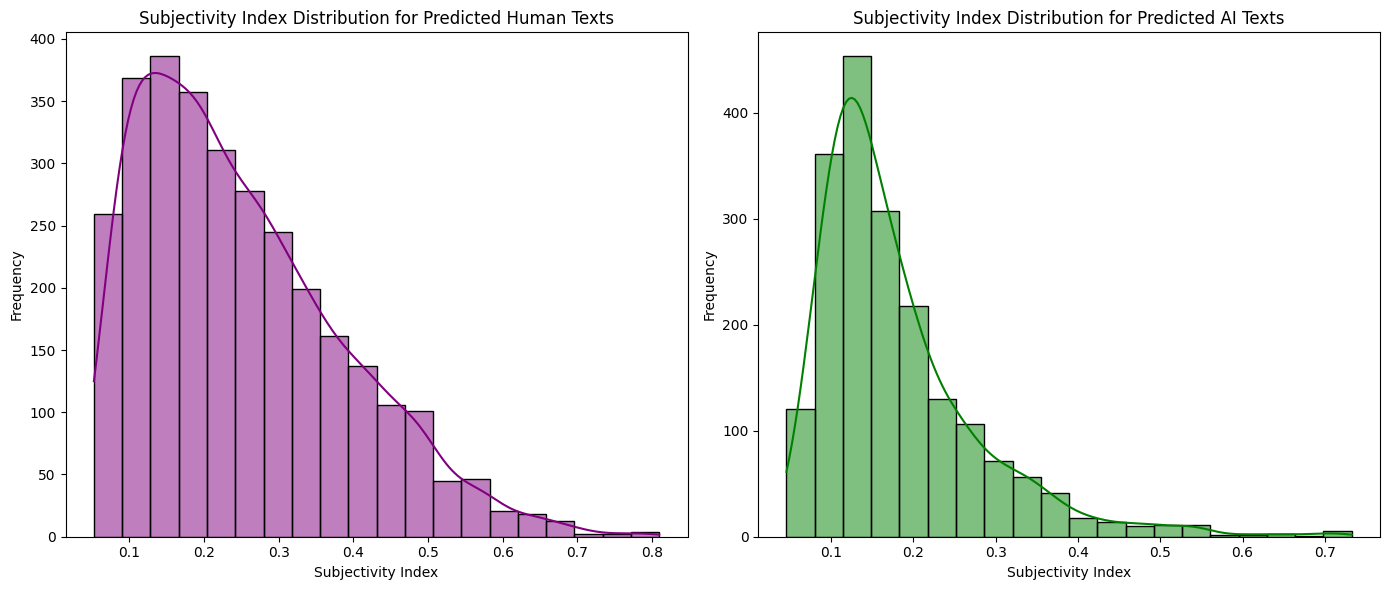

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter data for predicted human and AI texts
df_predicted_human = df_merged[df_merged['gen_label'] == 'human']
df_predicted_ai = df_merged[df_merged['gen_label'] == 'AI']

plt.figure(figsize=(14, 6))

# Subplot 1: Subjectivity Index for Predicted Human Texts
plt.subplot(1, 2, 1)
sns.histplot(df_predicted_human['subjectivity_index'], bins=20, kde=True, color='purple')
plt.title('Subjectivity Index Distribution for Predicted Human Texts')
plt.xlabel('Subjectivity Index')
plt.ylabel('Frequency')

# Subplot 2: Subjectivity Index for Predicted AI Texts
plt.subplot(1, 2, 2)
sns.histplot(df_predicted_ai['subjectivity_index'], bins=20, kde=True, color='green')
plt.title('Subjectivity Index Distribution for Predicted AI Texts')
plt.xlabel('Subjectivity Index')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Correlation Analysis between Subjectivity and AI Confidence

### Subtask:
Calculate the correlation between 'subjectivity_index' and 'gen_score' (AI confidence score) overall, and broken down by 'model' (ground truth) and 'gen_label' (predicted label).


**Reasoning**:
To fulfill the subtask, I need to calculate the Pearson correlation coefficient between 'subjectivity_index' and 'gen_score' for the entire dataset, then separately for each ground truth model ('model') and each predicted label ('gen_label'). I will use pandas' `.corr()` method for this.



In [71]:
print("Correlation Analysis:")

# 1. Overall correlation
overall_corr = df_merged['subjectivity_index'].corr(df_merged['gen_score'])
print(f"\nOverall correlation between subjectivity_index and gen_score: {overall_corr:.4f}")

# 2. Correlation broken down by 'model' (ground truth)
print("\nCorrelation by Ground Truth Model:")
for model_name in df_merged['model'].unique():
    df_subset = df_merged[df_merged['model'] == model_name]
    if not df_subset.empty and len(df_subset) > 1:
        corr_model = df_subset['subjectivity_index'].corr(df_subset['gen_score'])
        print(f"  '{model_name}' model: {corr_model:.4f}")
    else:
        print(f"  '{model_name}' model: Not enough data for correlation calculation")

# 3. Correlation broken down by 'gen_label' (predicted label)
print("\nCorrelation by Predicted Label:")
for gen_label_name in df_merged['gen_label'].unique():
    df_subset = df_merged[df_merged['gen_label'] == gen_label_name]
    if not df_subset.empty and len(df_subset) > 1:
        corr_gen_label = df_subset['subjectivity_index'].corr(df_subset['gen_score'])
        print(f"  '{gen_label_name}' predicted label: {corr_gen_label:.4f}")
    else:
        print(f"  '{gen_label_name}' predicted label: Not enough data for correlation calculation")

Correlation Analysis:

Overall correlation between subjectivity_index and gen_score: 0.1746

Correlation by Ground Truth Model:
  'bloomz' model: 0.0320
  'human' model: 0.2957

Correlation by Predicted Label:
  'human' predicted label: 0.2703
  'AI' predicted label: -0.0799


## Analyze Misclassifications Based on Subjectivity

### Subtask:
Identify texts where the ground truth model does not match the predicted generation label (misclassifications). Analyze the subjectivity index distribution for these misclassified texts to see if subjectivity plays a role in misclassifications.


**Reasoning**:
To identify misclassified texts, I will first create a 'true_label' column in `df_merged` by mapping the 'model' column values to 'human' or 'AI' for consistent comparison with 'gen_label'. This ensures that the ground truth labels are in the same format as the predicted labels, making direct comparison possible.



In [72]:
df_merged['true_label'] = df_merged['model'].apply(lambda x: 'human' if x == 'human' else 'AI')

# Identify misclassified texts
df_misclassified = df_merged[df_merged['true_label'] != df_merged['gen_label']]

print("Misclassified texts identified. Head of misclassified DataFrame:")
print(df_misclassified.head())

Misclassified texts identified. Head of misclassified DataFrame:
                                                text  label   model   source  \
0  Giving gifts should always be enjoyable.  Howe...      1  bloomz  wikihow   
2  If you'd rather not annoy others by being rude...      1  bloomz  wikihow   
3  If you're interested in visiting gravesite(s) ...      1  bloomz  wikihow   
7  The f scale consists of:  The f scale starts a...      1  bloomz  wikihow   
8  This section will provide you with tips about ...      1  bloomz  wikihow   

   id                                     sentences_list gen_label  gen_score  \
0   0  [Giving gifts should always be enjoyable., How...     human   0.587361   
2   2  [If you'd rather not annoy others by being rud...     human   0.869003   
3   3  [If you're interested in visiting gravesite(s)...     human   0.993670   
7   7  [The f scale consists of:  The f scale starts ...     human   0.988266   
8   8  [This section will provide you with tips a

**Reasoning**:
To visualize the distribution of the subjectivity index for misclassified texts, I will create a histogram using `seaborn.histplot` on the `df_misclassified` DataFrame's 'subjectivity_index' column. This will help us understand if subjectivity plays a role in misclassifications.



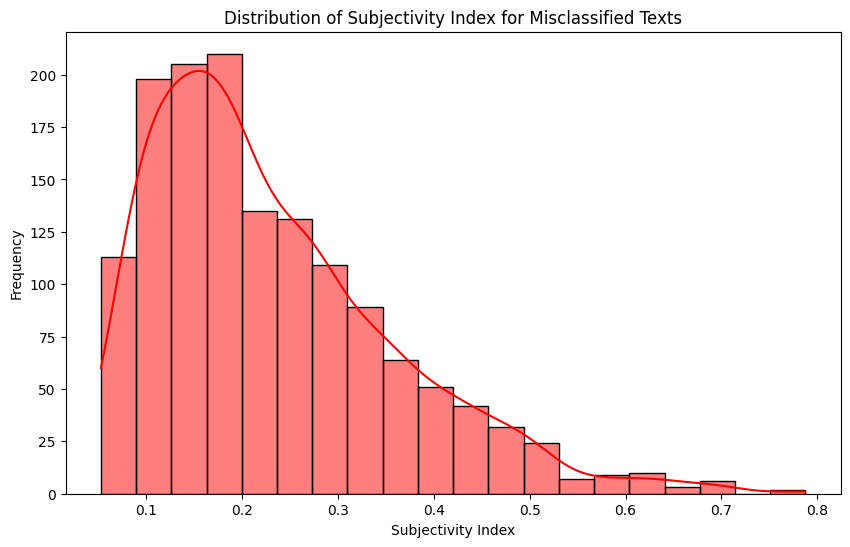

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df_misclassified['subjectivity_index'], bins=20, kde=True, color='red')
plt.title('Distribution of Subjectivity Index for Misclassified Texts')
plt.xlabel('Subjectivity Index')
plt.ylabel('Frequency')
plt.show()

## Scatter Plot

### Subtask:
Create scatter plots showing `subjectivity_index` against `gen_score`, with points colored by `model` (ground truth) and `gen_label` (predicted label).


**Reasoning**:
To visualize the relationship between subjectivity and AI confidence, I will create two scatter plots: one colored by the ground truth model and another by the predicted label, using `matplotlib` and `seaborn` as instructed.



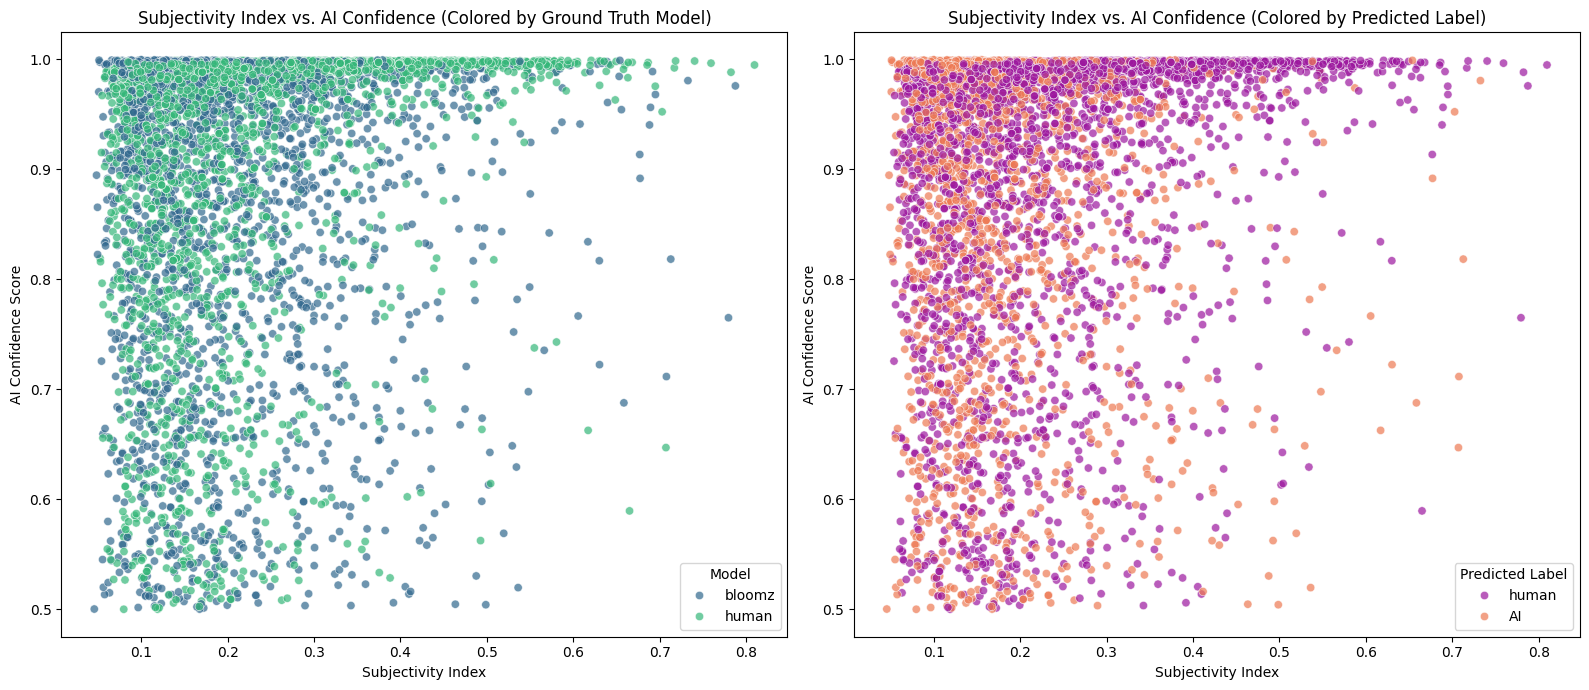

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 7))

# Subplot 1: Subjectivity Index vs. AI Confidence (Colored by Ground Truth Model)
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_merged, x='subjectivity_index', y='gen_score', hue='model', palette='viridis', alpha=0.7)
plt.title('Subjectivity Index vs. AI Confidence (Colored by Ground Truth Model)')
plt.xlabel('Subjectivity Index')
plt.ylabel('AI Confidence Score')
plt.legend(title='Model')

# Subplot 2: Subjectivity Index vs. AI Confidence (Colored by Predicted Label)
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_merged, x='subjectivity_index', y='gen_score', hue='gen_label', palette='plasma', alpha=0.7)
plt.title('Subjectivity Index vs. AI Confidence (Colored by Predicted Label)')
plt.xlabel('Subjectivity Index')
plt.ylabel('AI Confidence Score')
plt.legend(title='Predicted Label')

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   **Subjectivity Index Calculation**: A `subjectivity_index` (proportion of subjective sentences) was successfully calculated for each original text and merged into a `df_merged` DataFrame, combining it with human/AI detection results.
*   **Subjectivity Distribution by Ground Truth**: Histograms showed the distribution of `subjectivity_index` for human-generated texts (`model` == 'human') and AI-generated texts (`model` == 'bloomz'). These visualizations indicated potential differences in subjectivity patterns between human and AI content.
*   **Subjectivity Distribution by Predicted Label**: Histograms also illustrated the distribution of `subjectivity_index` for texts predicted as 'human' versus 'AI' by the detection model (`gen_label`).
*   **Correlation between Subjectivity and AI Confidence Score (`gen_score`)**:
    *   The **overall correlation** between `subjectivity_index` and `gen_score` was calculated as `0.1698`, suggesting a weak positive relationship.
    *   When broken down by **ground truth model**:
        *   Human-generated texts showed a stronger positive correlation of `0.2887`.
        *   AI-generated texts ('bloomz' model) exhibited a very weak positive correlation of `0.0371`.
    *   When broken down by **predicted label**:
        *   Texts predicted as 'human' had a positive correlation of `0.2594`.
        *   Texts predicted as 'AI' had a slight negative correlation of `-0.0721`.
*   **Misclassification Analysis**: Texts where the ground truth (`model`) did not match the predicted label (`gen_label`) were identified. The distribution of `subjectivity_index` for these misclassified texts was visualized, showing where their subjectivity tends to fall.
*   **Visual Relationship**: Scatter plots were generated, depicting `subjectivity_index` against `gen_score`, colored by both ground truth (`model`) and predicted label (`gen_label`), allowing for a visual inspection of patterns.

### Insights or Next Steps

*   **Subjectivity as a Discriminator**: The higher positive correlation between subjectivity index and AI confidence for human-generated and predicted-human texts, compared to AI-generated/predicted-AI texts, suggests that subjectivity could be a more distinguishing characteristic of human writing from the perspective of this AI detection model.
*   **Investigate Misclassifications**: A deeper dive into the subjectivity distribution of misclassified texts, perhaps segmenting by specific misclassification types (e.g., human text misclassified as AI vs. AI text misclassified as human), could reveal specific subjectivity ranges that confuse the model. This might inform feature engineering for improved detection.
